# Week 3: CNN Cancer Detection Kaggle Mini-Project

**Data Source**: https://www.kaggle.com/competitions/histopathologic-cancer-detection/

**Data Description**: 
* A large number of histopathological images for classification.  
* The original PCam dataset had duplicates, but this Kaggle dataset removed them, cleaning it up.  
* If a label is 0 then it is *begin*, or 1 is *malignant*.  
* The positive label is only associated with the 32x32 px region in the center of each tissue sample image.  

## 1.  EDA 

### 1.1 Import Libraries

In [1]:
import os
import datetime
import yaml
import ultralytics
from ultralytics import YOLO
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import logging
logging.getLogger().setLevel(logging.ERROR)
import sys
sys.path.append("YOLO-V8-CAM")


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.2 Read in Paths
* There are *train/test* folders of images with label files for the training set.  
* The *test* folder is used for inference to submit for the Kaggle competition.

In [2]:
path_train_imgs = r"train"
path_test_imgs = r"test"
path_sample_submission = r"sample_submission.csv"
path_train_labels = r"train_labels.csv"

In [3]:
train_labels_OG = pd.read_csv(path_train_labels)

In [4]:
N_TRAIN_imgs = len(os.listdir(path_train_imgs))
N_TEST_imgs = len(os.listdir(path_test_imgs))
print(f"There are {N_TRAIN_imgs} TRAIN images and {N_TEST_imgs} TEST images.")

There are 220025 TRAIN images and 57458 TEST images.


### 1.3 Visualize Data
* We want to first inspect a few of the images to see what our data looks like.
* We will plot both images that are of both classes.

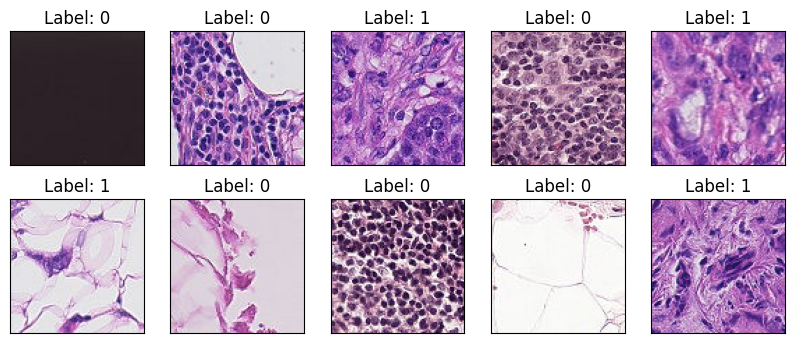

In [5]:
fig = plt.figure(figsize=(10, 4))
train_imgs = os.listdir(path_train_imgs)
for i, img in enumerate(np.random.choice(train_imgs, 10)):
    ax = fig.add_subplot(2, 10//2, i+1, xticks=[], yticks=[])
    im = Image.open(os.path.join(path_train_imgs,img))
    plt.imshow(im)
    lab = train_labels_OG.loc[train_labels_OG['id'] == img.split('.')[0], 'label'].values[0]
    
    ax.set_title(f'Label: {lab}')

### 1.4 Split Data
* We want to split our train data into *train*, *valid*, and *test* for training purposes.  
* We will use a 80/20 split for *train* vs. combined *valid*/*test*.
* We will split the remaining 20 into 10 and 10 for *valid* and *test*.  This allows for a more fair unbiased test set.

In [6]:
train_labels, test_labels = train_test_split(train_labels_OG, stratify=train_labels_OG.label, test_size=0.8,random_state=42)
train_labels, valid_labels = train_test_split(train_labels, stratify=train_labels.label, test_size=0.1,random_state=42)


In [7]:
train_labels

id  label
30834   8424aa45bf50a4e61dfc9d98c86ae8e4ad1905e5      0
138386  41e4331735a50f61d3535232aa8dc8e1c89e8a7a      0
34047   2be99c4418dbeb7c96353c64f3e047024fc0f51d      0
17964   28c28a457c2bda833e1e7d8cb0064cb27070cc0e      1
3738    008d4e832444baa5819705a9f17eb8ca77fe4f4f      1
...                                          ...    ...
183812  1650d9e0aa506e8adaee294865bac7930538b929      0
148149  32fa97489e3a5b3960153f4580ebce5158ff6bb7      0
26834   d8638e6f258a7f4c7383d6e188209aae34982ed6      1
198933  7bc3de585214a4ace7e311a99310aa5894f73f4d      0
160260  57d3d479abe6b214bd832f6e7f7bb5d017d78f4e      0

[39604 rows x 2 columns]

#### 1.4.1 Cropping Out Center Regions
* I want to crop the original images to 32x32 regions that are the location where the labels are associated with.
* I also want to make the directory scheme favorable for training with YOLOv8 classifiers.

In [8]:
# data can be cropped to 32x32 in center since that is where the label is determined.
def center_crop_32x32(image):
    width, height = image.size  
    new_width, new_height = 32, 32

    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2

    return image.crop((left, top, right, bottom)) 

In [9]:
MAX_NUM=100000000 #arbitrary large number to ensure we capture all of the training data for splitting and cropping
# MAX_NUM=1000
# MAX_NUM = 999999999
import shutil
from tqdm import tqdm
path_yolo = f"yolo_data_{MAX_NUM}"
if os.path.exists(path_yolo)==False:
    os.makedirs(path_yolo)
path_yolo_train = os.path.join(path_yolo,"train")
path_yolo_valid = os.path.join(path_yolo,"valid")
path_yolo_test = os.path.join(path_yolo,"test")
def mk_1_0(path_yolo_i):
    path_1 = os.path.join(path_yolo_i,"1")
    path_0 = os.path.join(path_yolo_i,"0")
    if os.path.exists(path_1)==False:
        os.makedirs(path_1)
    if os.path.exists(path_0)==False:
        os.makedirs(path_0)
    return path_0,path_1
path_yolo_train_0,path_yolo_train_1 = mk_1_0(path_yolo_train)
path_yolo_valid_0,path_yolo_valid_1 = mk_1_0(path_yolo_valid)
path_yolo_test_0,path_yolo_test_1 = mk_1_0(path_yolo_test)

def shutil_yolo(cat_i, labels_i, path_og, path_output, MAX_NUM=MAX_NUM):
    labels_i = labels_i.sort_values(by="id").reset_index().drop("index", axis=1)
    labels_i = labels_i.sample(n=min(len(labels_i),MAX_NUM))  # Sample MAX_NUM entries
    labels_i = labels_i.sort_values(by="id").reset_index().drop("index", axis=1)
    df_i = labels_i[labels_i["label"] == cat_i].reset_index().drop("index", axis=1)
    files_output = os.listdir(path_output)
    for id_i in tqdm(range(len(df_i))):
        file_i = os.path.join(path_og, df_i["id"].loc[id_i] + ".tif")
        base_i = os.path.basename(file_i)

        if base_i not in files_output and os.path.exists(file_i):
            img = Image.open(file_i)
            cropped_img = center_crop_32x32(img)
            output_path = os.path.join(path_output, base_i)
            cropped_img.save(output_path)
            
RUN_SPLIT = False
if RUN_SPLIT:
    #train_0
    cat_i = 0
    labels_i = train_labels
    path_og = path_train_imgs
    path_output = path_yolo_train_0
    shutil_yolo(cat_i,labels_i,path_og,path_output)

    #train_1
    cat_i = 1
    labels_i = train_labels
    path_og = path_train_imgs
    path_output = path_yolo_train_1
    shutil_yolo(cat_i,labels_i,path_og,path_output)  

    #valid_0
    cat_i = 0
    labels_i = valid_labels
    path_og = path_train_imgs
    path_output = path_yolo_valid_0
    shutil_yolo(cat_i,labels_i,path_og,path_output) 

    #valid_1
    cat_i = 1
    labels_i = valid_labels
    path_og = path_train_imgs
    path_output = path_yolo_valid_1
    shutil_yolo(cat_i,labels_i,path_og,path_output)  

    #test_0
    cat_i = 0
    labels_i = test_labels
    path_og = path_train_imgs
    path_output = path_yolo_test_0
    shutil_yolo(cat_i,labels_i,path_og,path_output) 

    #test_1
    cat_i = 1
    labels_i = test_labels
    path_og = path_train_imgs
    path_output = path_yolo_test_1
    shutil_yolo(cat_i,labels_i,path_og,path_output)  

## 2. Model Training
* I will train a variety of binary classification architectures:
    * YOLOv8n-cls
    * YOLOv8l-cls
* I will use RayTune for tuning hyperparameters and different augmentation techniques
    * Image Augmentations:
        * mixup
        * mosaic
        * fliplr
        * flipud
    * Hyperparameters
        * momentum
        * optimizers
            * AdamN
            * SGD
        * learning rates


### 2.1 Training with Script
* I will train the models with a separate script, **ray_tune_trainer_custom.py**
* I will use **nohup** to run the script outside of this environment.
* I will use a logical variable **TRAIN_MODELS** for training or passing by an already trained script. 

In [10]:
from pprint import pprint
script = "ray_tune_trainer_custom.py"
with open(script,"r") as f:
    f_read = f.readlines()
pprint(f_read)

['from ultralytics import YOLO\n',
 'import os\n',
 'import ray\n',
 'from ray import tune\n',
 'from ray.tune.search.hyperopt import HyperOptSearch\n',
 'from ray.air import session\n',
 'import datetime\n',
 '\n',
 'from ray.tune.schedulers import ASHAScheduler\n',
 'cwd = os.getcwd()\n',
 'date_i = str(datetime.datetime.now()).replace(" ","_").replace(".","p")\n',
 '\n',
 "'''\n",
 'asha_scheduler:\n',
 '  * metric: is for the metric to schedule with\n',
 '  * mode: the max is used to maximize the metric\n',
 '  * max_t: 100 is used as the maximum number of trials\n',
 '  * grace_period: This is for how many trials to go without terminating if '
 'metric is not improving\n',
 '  * \n',
 "'''\n",
 'asha_scheduler = ASHAScheduler(\n',
 '    metric="metrics/accuracy_top1",    \n',
 '    mode="max",              \n',
 '    max_t=100,                 \n',
 '    grace_period=2,            \n',
 '    reduction_factor=2         \n',
 ')\n',
 "'''\n",
 'ray.init:\n',
 "    * num_gpus: set to

In [24]:
TRAIN_MODELS = False
if TRAIN_MODELS:
    os.system("nohup python3 ray_tune_trainer_custom.py > ray_tune_trainer_custom.log 2>&1 &")

### 2.2 Reading in Models
* RayTune script was setup to export the models to a directory associated with datetime and *RAYTUNE_MODELS_NEW*.
* I will read in those model paths and the associated weights, results, and yaml args.

In [25]:
TRAIN_MODELS_PATHS  = os.listdir()
TRAIN_MODELS_PATHS = [w for w in TRAIN_MODELS_PATHS if w.find("RAYTUNE_MODELS_NEW")!=-1]
TRAIN_MODELS_PATHS

['RAYTUNE_MODELS_NEW_2024-10-04_19:16:51p630169',
 'RAYTUNE_MODELS_NEW_2024-10-05_11:31:27p704361']

In [26]:
projects = []
for path_i in TRAIN_MODELS_PATHS:
    projects += [os.path.join(path_i,w) for w in os.listdir(path_i)]
projects

['RAYTUNE_MODELS_NEW_2024-10-04_19:16:51p630169/yolov8l-cls',
 'RAYTUNE_MODELS_NEW_2024-10-05_11:31:27p704361/yolov8n-cls']

In [61]:
names_found_all = []
weights_found = {}
for project in projects:
    names_found = os.listdir(project)
    names_found = [w for w in names_found if os.path.exists(os.path.join(project,w,"weights","best.pt"))]
    for name_i in names_found:
        path_weights = os.path.join(project,name_i,"weights","best.pt")
        path_results = os.path.join(project,name_i,"results.csv")
        args_path = os.path.join(project,name_i,"args.yaml" )
        weights_found[name_i] = [path_weights,path_results,args_path]

### 2.3 Visualizing Model Results
* I will use a third party library **YOLO-V8-CAM** in order to visualize the gradients with each model understand which parts of the image were being focused for *benign* vs. *malignant*

In [99]:
def save_grad_cam(model,input_img_path,save_img_path):
    from yolo_cam.eigen_cam import EigenCAM
    from yolo_cam.utils.image import show_cam_on_image, scale_cam_image
    import torch
    import cv2

    target_layers = [model.model.model[-1].conv]
    image_path = input_img_path
    img = cv2.imread(image_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cam = EigenCAM(model, target_layers,task='cls')
    grayscale_cam = cam(rgb_img)[0, :, :]
    show_img = np.array(img).astype(np.float32)
    show_img /= 255.0
    visualization = show_cam_on_image(show_img, grayscale_cam, use_rgb=True)

    cv2.imwrite(save_img_path, visualization)
    og_img = os.path.join(os.path.dirname(save_img_path),os.path.basename(input_img_path))
    cv2.imwrite(og_img,img)


### 2.3.1 Visualize Model Gradients for Malignant 
* I will run through each model trained
* I will generate a Gradient on the last layer of the model by passing through an image from the training set
* I will save off these Gradient images for visualization and inspect a few here.

In [ ]:

train_imgs = sorted(os.listdir(path_yolo_train_1))
max_acc_i = 0
max_path_1 = None
for k,v in weights_found.items():
    model_i_path = weights_found[k][0]
    model = YOLO(model_i_path)
    df_i = pd.read_csv(weights_found[k][1])
    acc_i = df_i["  metrics/accuracy_top1"].max()


    GRAD_CAM_SAMPLES_PATH_I = os.path.join(os.path.dirname(os.path.dirname(model.ckpt_path)),"GRADCAM_SAMPLES_1")
    GRAD_CAM_SAMPLES_PATH_J = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(model.ckpt_path)))),"GRADCAM_SAMPLES_1")
    
    if os.path.exists(GRAD_CAM_SAMPLES_PATH_I)==False:
        os.makedirs(GRAD_CAM_SAMPLES_PATH_I)
    else:
        os.system(f"rm -rf {GRAD_CAM_SAMPLES_PATH_I}")
        os.makedirs(GRAD_CAM_SAMPLES_PATH_I)

    if os.path.exists(GRAD_CAM_SAMPLES_PATH_J)==False:
        os.makedirs(GRAD_CAM_SAMPLES_PATH_J)
    else:
        pass

    fig = plt.figure(figsize=(20, 8))  # Increase figure size for better visualization
    # train_imgs = os.listdir(path_train_imgs)
    fig.suptitle(f"Model = {k}, Acc = {acc_i}")

    # for i, img in enumerate(np.random.choice(train_imgs, 5)):  # Reduced to 5 pairs for clearer display
    for i, img in enumerate(train_imgs[0:5]):  # Reduced to 5 pairs for clearer display
        # Load input image
        input_img_path = os.path.join(path_train_imgs, img)
        input_image = Image.open(input_img_path)

        # Generate Grad-CAM image
        output_img_path = os.path.join(GRAD_CAM_SAMPLES_PATH_I, img.split(".")[0] + "_gradcam.jpg")
        save_grad_cam(model, input_img_path=input_img_path, save_img_path=output_img_path)  # Assuming save_grad_cam saves Grad-CAM
        grad_cam_image = Image.open(output_img_path)
        
        # Plot Input Image
        ax1 = fig.add_subplot(2, 5, 2*i+1, xticks=[], yticks=[])  # 2 rows, 5 columns
        ax1.imshow(input_image)
        lab = train_labels_OG.loc[train_labels_OG['id'] == img.split('.')[0], 'label'].values[0]
        ax1.set_title(f'Input - Label: {lab}')

        # Plot Grad-CAM Image
        ax2 = fig.add_subplot(2, 5, 2*i+2, xticks=[], yticks=[])  # Next column for Grad-CAM
        ax2.imshow(grad_cam_image)
        ax2.set_title(f'Grad-CAM')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(os.path.join(GRAD_CAM_SAMPLES_PATH_I,"SUBSET_GRAD_CAM.jpg"))
    plt.savefig(os.path.join(GRAD_CAM_SAMPLES_PATH_J,os.path.basename(os.path.dirname(os.path.dirname(model.ckpt_path)))+"_SUBSET_GRAD_CAM.jpg"))
    if acc_i> max_acc_i:
        max_acc_i = acc_i
        max_path_1 =  os.path.join(GRAD_CAM_SAMPLES_PATH_J,os.path.basename(os.path.dirname(os.path.dirname(model.ckpt_path)))+"_SUBSET_GRAD_CAM.jpg")
        
    #plt.show()
    


### 2.3.2 Visualize Model Gradients for Begin 
* I will run through each model trained
* I will generate a Gradient on the last layer of the model by passing through an image from the training set
* I will save off these Gradient images for visualization and inspect a few here.

In [ ]:
train_imgs = sorted(os.listdir(path_yolo_train_0))
max_acc_i = 0
max_path_0 = None
for k,v in weights_found.items():
    model_i_path = weights_found[k][0]
    model = YOLO(model_i_path)
    df_i = pd.read_csv(weights_found[k][1])
    acc_i = df_i["  metrics/accuracy_top1"].max()

    GRAD_CAM_SAMPLES_PATH_I = os.path.join(os.path.dirname(os.path.dirname(model.ckpt_path)),"GRADCAM_SAMPLES_0")
    GRAD_CAM_SAMPLES_PATH_J = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(model.ckpt_path)))),"GRADCAM_SAMPLES_0")
    
    if os.path.exists(GRAD_CAM_SAMPLES_PATH_I)==False:
        os.makedirs(GRAD_CAM_SAMPLES_PATH_I)
    else:
        os.system(f"rm -rf {GRAD_CAM_SAMPLES_PATH_I}")
        os.makedirs(GRAD_CAM_SAMPLES_PATH_I)

    if os.path.exists(GRAD_CAM_SAMPLES_PATH_J)==False:
        os.makedirs(GRAD_CAM_SAMPLES_PATH_J)
    else:
        pass
        # os.system(f"rm -rf {GRAD_CAM_SAMPLES_PATH_J}")
        # os.makedirs(GRAD_CAM_SAMPLES_PATH_J)

    fig = plt.figure(figsize=(20, 8))  # Increase figure size for better visualization
    # train_imgs = os.listdir(path_train_imgs)
    fig.suptitle(f"Model = {k}, Acc = {acc_i}")

    # for i, img in enumerate(np.random.choice(train_imgs, 5)):  # Reduced to 5 pairs for clearer display
    for i, img in enumerate(train_imgs[0:5]):  # Reduced to 5 pairs for clearer display
        # Load input image
        input_img_path = os.path.join(path_train_imgs, img)
        input_image = Image.open(input_img_path)

        # Generate Grad-CAM image
        output_img_path = os.path.join(GRAD_CAM_SAMPLES_PATH_I, img.split(".")[0] + "_gradcam.jpg")
        save_grad_cam(model, input_img_path=input_img_path, save_img_path=output_img_path)  # Assuming save_grad_cam saves Grad-CAM
        grad_cam_image = Image.open(output_img_path)
        
        # Plot Input Image
        ax1 = fig.add_subplot(2, 5, 2*i+1, xticks=[], yticks=[])  # 2 rows, 5 columns
        ax1.imshow(input_image)
        lab = train_labels_OG.loc[train_labels_OG['id'] == img.split('.')[0], 'label'].values[0]
        ax1.set_title(f'Input - Label: {lab}')

        # Plot Grad-CAM Image
        ax2 = fig.add_subplot(2, 5, 2*i+2, xticks=[], yticks=[])  # Next column for Grad-CAM
        ax2.imshow(grad_cam_image)
        ax2.set_title(f'Grad-CAM')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.savefig(os.path.join(GRAD_CAM_SAMPLES_PATH_I,"SUBSET_GRAD_CAM.jpg"))
    plt.savefig(os.path.join(GRAD_CAM_SAMPLES_PATH_J,os.path.basename(os.path.dirname(os.path.dirname(model.ckpt_path)))+"_SUBSET_GRAD_CAM.jpg"))
    if acc_i> max_acc_i:
        max_acc_i = acc_i
        max_path_0 =  os.path.join(GRAD_CAM_SAMPLES_PATH_J,os.path.basename(os.path.dirname(os.path.dirname(model.ckpt_path)))+"_SUBSET_GRAD_CAM.jpg")
        
    #plt.show()
    


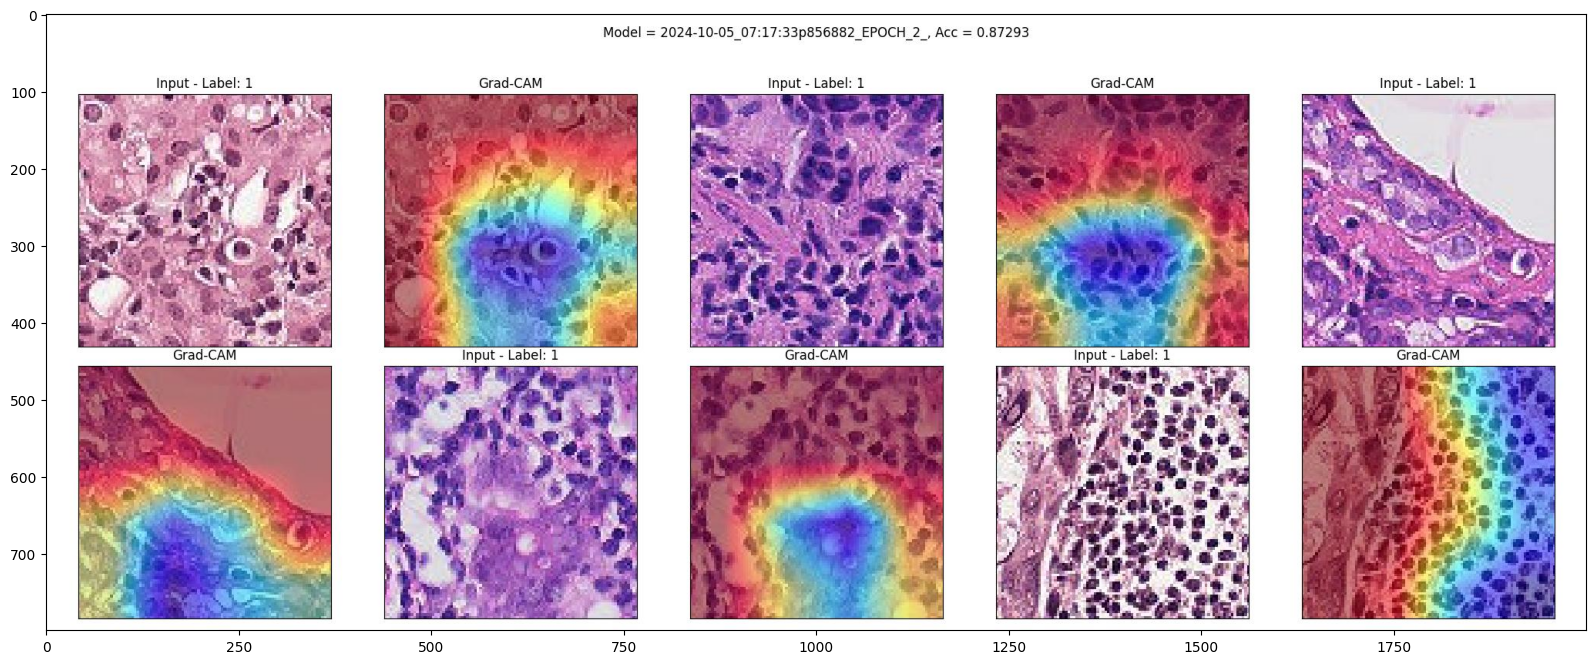

In [111]:
plt.figure(figsize=(20, 8))
plt.imshow(plt.imread(max_path_1))
plt.show()

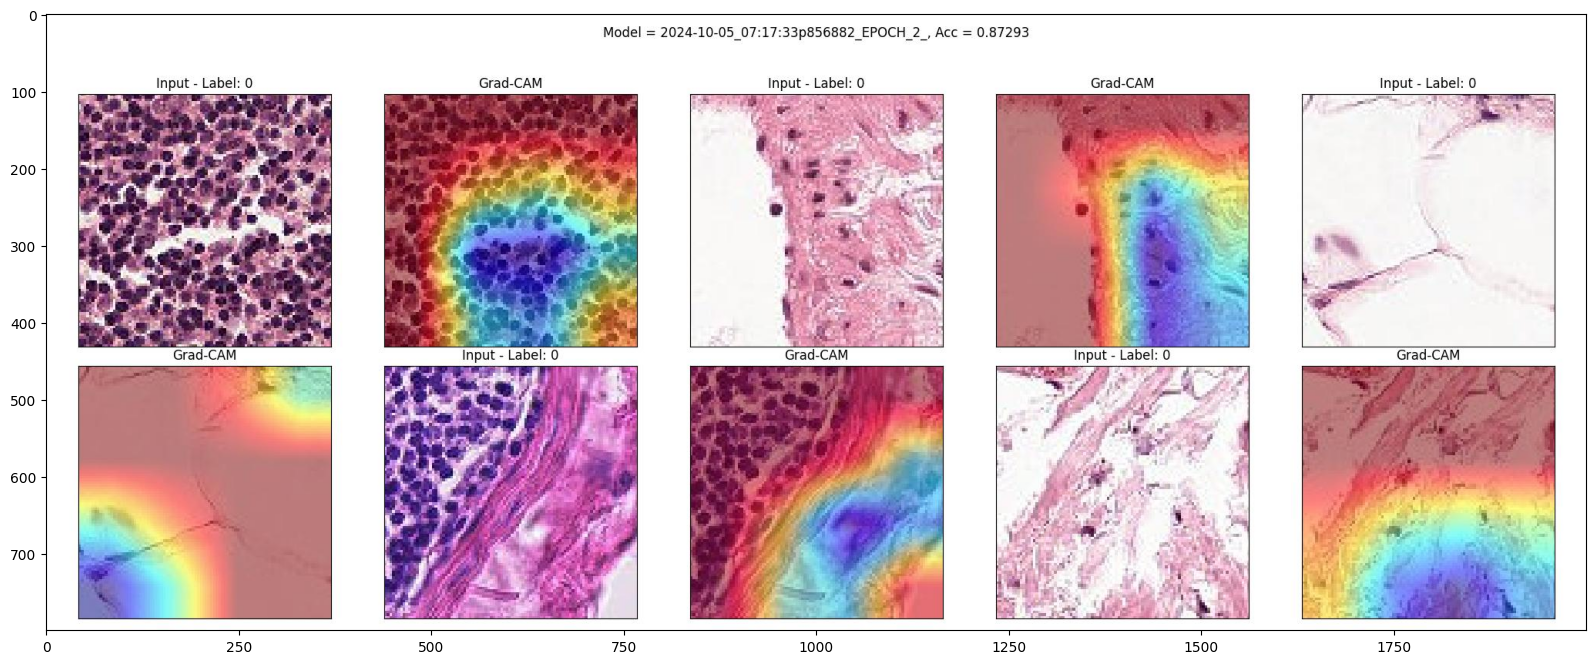

In [112]:
plt.figure(figsize=(20, 8))
plt.imshow(plt.imread(max_path_0))
plt.show()

# 3. Results & Analysis 
* I will read in each result file for each model generated and merge the model with its yaml file for hyperparameters used.
* I will sort them by accuracy and remove duplicates per model to see the top models by hyperparameter.
    * It appears SGD optimizer with the larger architecture of YOLOv8l-cls performed best.
* I will take the best model from this list and inference on the *TEST* set for uploading results to Kaggle

In [83]:
dfs = []
df_yamls = []
for k,v in weights_found.items():
    model_i_path = weights_found[k][0]
    yaml_i =v[2]
    df_yaml_i = pd.read_csv(yaml_i)
    with open(yaml_i, 'r') as file:
        args_i = yaml.safe_load(file)
    df_yaml_i = pd.DataFrame([args_i])
    df_yaml_i.drop(["model"],axis=1,inplace=True)
    df_yaml_i.columns = df_yaml_i.columns.str.replace(" ","")
    arg_keep_cols = ["name","mixup","fliplr","flipud","mosaic","batch","optimizer","momentum"]
    df_yaml_i = df_yaml_i[arg_keep_cols]
    

    df_i = pd.read_csv(weights_found[k][1])
    df_i.columns = df_i.columns.str.replace(' ', '')
    

    df_i.drop(["epoch"],axis=1,inplace=True)
    df_i["epoch"] = k.split("EPOCH_")[-1].split("_")[0]
    df_i["name"] = k
    df_i["model"] = k.split("_EPOCH")[0]
    df_i["arch_i"] = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(v[0]))))
    df_i["weights_path"] = model_i_path
    dfs.append(df_i)
    df_yamls.append(df_yaml_i)
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.columns = combined_df.columns.str.replace(' ', '', regex=True)
combined_df_yamls = pd.concat(df_yamls, ignore_index=True)
combined_df_yamls.columns = combined_df_yamls.columns.str.replace(' ', '', regex=True)


In [84]:
combined_df = pd.merge(combined_df,combined_df_yamls,on=["name"])

The *SGD* optimizer combined with the larger architecture *YOLOv8l-cls* performed best among the case study.

In [85]:
combined_df.sort_values(by="metrics/accuracy_top1",ascending=False).drop_duplicates("model")

train/loss  metrics/accuracy_top1  metrics/accuracy_top5  val/loss  \
18     0.16043                0.87293                      1   0.45081   
2      0.07984                0.87224                      1   0.22548   
11     0.16115                0.87215                      1   0.45114   
33     0.16087                0.87020                      1   0.45217   
31     0.15995                0.86906                      1   0.45330   
70     0.16065                0.86902                      1   0.45478   
20     0.19390                0.86684                      1   0.46155   
9      0.19509                0.86665                      1   0.46153   
8      0.19553                0.86575                      1   0.46269   
48     0.10272                0.86502                      1   0.23469   
10     0.10297                0.86497                      1   0.23460   
34     0.10279                0.86488                      1   0.23376   
36     0.21957                0.85275                      1   0.47430   
54     0.21131                0.84975                      1   0.48216   
16     0.11470                0.84670                      1   0.24052   
23     0.11467                0.84443                      1   0.24090   
30     0.11471                0.84375                      1   0.24020   
57     0.11225                0.83998                      1   0.24735   
62     0.11210                0.83993                      1   0.24493   
53     0.21320                0.83852                      1   0.48555   
66     0.11275                0.83511                      1   0.24670   
71     0.21168                0.83370                      1   0.49612   
14     0.11424                0.83311                      1   0.24919   
43     0.11427                0.83289                      1   0.24913   
21     0.11423                0.83139                      1   0.24947   
19     0.11446                0.82798                      1   0.24940   
4      0.21815                0.82730                      1   0.50094   
35     0.21754                0.82143                      1   0.50351   
3      0.21767                0.80280                      1   0.51802   

      lr/pg0    lr/pg1    lr/pg2 epoch                                 name  \
18  0.070005  0.003333  0.003333     2  2024-10-05_07:17:33p856882_EPOCH_2_   
2   0.070003  0.003333  0.003333     3  2024-10-04_19:17:04p797879_EPOCH_3_   
11  0.070005  0.003333  0.003333     2  2024-10-05_04:51:15p732092_EPOCH_2_   
33  0.070005  0.003333  0.003333     2  2024-10-04_23:06:15p543278_EPOCH_2_   
31  0.070005  0.003333  0.003333     2  2024-10-04_21:45:33p480691_EPOCH_2_   
70  0.070005  0.003333  0.003333     4  2024-10-05_13:04:07p152518_EPOCH_4_   
20  0.070005  0.003333  0.003333     1  2024-10-05_00:49:57p057065_EPOCH_1_   
9   0.070005  0.003333  0.003333     1  2024-10-04_22:38:57p321382_EPOCH_1_   
8   0.070005  0.003333  0.003333     1  2024-10-05_09:28:08p649700_EPOCH_1_   
48  0.070003  0.003333  0.003333     1  2024-10-05_08:43:06p323955_EPOCH_1_   
10  0.070003  0.003333  0.003333     1  2024-10-05_03:26:40p088012_EPOCH_1_   
34  0.070003  0.003333  0.003333     1  2024-10-05_06:13:22p349438_EPOCH_1_   
36  0.070005  0.003333  0.003333     0  2024-10-05_09:54:46p660577_EPOCH_0_   
54  0.070005  0.003333  0.003333     0  2024-10-05_14:50:29p014982_EPOCH_0_   
16  0.070003  0.003333  0.003333     0  2024-10-05_01:33:14p954723_EPOCH_0_   
23  0.070003  0.003333  0.003333     0  2024-10-05_06:56:59p299249_EPOCH_0_   
30  0.070003  0.003333  0.003333     0  2024-10-05_00:28:10p244532_EPOCH_0_   
57  0.070003  0.003333  0.003333     0  2024-10-05_15:10:44p262596_EPOCH_0_   
62  0.070003  0.003333  0.003333     2  2024-10-05_11:31:38p832615_EPOCH_2_   
53  0.070005  0.003333  0.003333     0  2024-10-05_14:14:10p134428_EPOCH_0_   
66  0.070003  0.003333  0.003333     0  2024-10-05_14:34:27p867424_EPOCH_0_   
71  0.070005  0.003333  0.003333     0  2024-

Our best model will be the one with the highest accuracy for top1

In [137]:
best_model_based_on_acc = combined_df.sort_values(by="metrics/accuracy_top1",ascending=False).drop_duplicates("model").model.iloc[0]
best_model_based_on_acc

'2024-10-05_07:17:33p856882'

In [138]:
best_weights_based_on_acc = combined_df.sort_values(by="metrics/accuracy_top1",ascending=False).drop_duplicates("model").weights_path.iloc[0]
best_weights_based_on_acc

'RAYTUNE_MODELS_NEW_2024-10-04_19:16:51p630169/yolov8l-cls/2024-10-05_07:17:33p856882_EPOCH_2_/weights/best.pt'

In [139]:
best_model_based_on_valloss = combined_df.sort_values(by="val/loss",ascending=True).drop_duplicates("model").model.iloc[0]
best_model_based_on_valloss

'2024-10-04_19:17:04p797879'

In [140]:
best_weights_based_on_valloss = combined_df.sort_values(by="val/loss",ascending=True).drop_duplicates("model").weights_path.iloc[0]
best_weights_based_on_valloss

'RAYTUNE_MODELS_NEW_2024-10-04_19:16:51p630169/yolov8l-cls/2024-10-04_19:17:04p797879_EPOCH_4_/weights/best.pt'

In [144]:
model_based_on_acc = YOLO(best_weights_based_on_acc)
model_based_on_valloss = YOLO(best_weights_based_on_valloss)
model_based_on_acc.info()

YOLOv8l-cls summary: 183 layers, 36202306 parameters, 0 gradients, 99.1 GFLOPs


(183, 36202306, 0, 99.1248384)

In [142]:
model_based_on_acc.model

ClassificationModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(320, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
   

We have to crop the test images like we did for the training set to inference with the YOLO models on

In [93]:
def shutil_yolo_TEST(path_og, path_output):
    files_output = os.listdir(path_output)
    og_imgs = os.listdir(path_og)
    og_imgs = [os.path.join(path_og,w) for w in og_imgs if w.endswith(".tif")]
    for file_i in tqdm(og_imgs):
        base_i = os.path.basename(file_i)
        if base_i not in files_output and os.path.exists(file_i):
            img = Image.open(file_i)
            cropped_img = center_crop_32x32(img)
            output_path = os.path.join(path_output, base_i)
            cropped_img.save(output_path)

In [94]:
path_YOLO_FINAL_TEST = "YOLO_FINAL_TEST"
if os.path.exists(path_YOLO_FINAL_TEST)==False:
    os.makedirs(path_YOLO_FINAL_TEST)
shutil_yolo_TEST(path_test_imgs,path_YOLO_FINAL_TEST)

100%|██████████| 57458/57458 [00:21<00:00, 2724.79it/s] 


In [143]:
results_based_on_acc = model_based_on_acc(path_YOLO_FINAL_TEST,save_txt=True,stream=True,verbose=False)

In [145]:
results_based_on_valloss = model_based_on_valloss(path_YOLO_FINAL_TEST,save_txt=True,stream=True,verbose=False)

In [146]:
df_submit = pd.read_csv(path_sample_submission)
df_submit

id  label
0      0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1      95596b92e5066c5c52466c90b69ff089b39f2737      0
2      248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3      2c35657e312966e9294eac6841726ff3a748febf      0
4      145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
...                                         ...    ...
57453  061847314ded6f81e1cd670748bfa2003442c9c7      0
57454  6f3977130212641fd5808210015a609c658dcbff      0
57455  46935f247278539eca74b54d07d666efb528a753      0
57456  a09bcae08a82120183352e0e869181b2911d3dc1      0
57457  d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b      0

[57458 rows x 2 columns]

In [147]:
df_submit["conf"] = 0.0

In [148]:
def update_df(results,df_submit):
    labels = []
    confs = []
    indices = []
    for result_i in tqdm(results):
        id_i = os.path.basename(result_i.path).split(".tif")[0]
        index_i = df_submit[df_submit.id == id_i].index[0]
        label_i = result_i.probs.top1
        conf_i = float(result_i.probs.top1conf.cpu())
        
        labels.append((index_i, label_i))
        confs.append((index_i, conf_i))

    df_submit.loc[[i for i, _ in labels], "label"] = [label for _, label in labels]
    df_submit.loc[[i for i, _ in confs], "conf"] = [conf for _, conf in confs]
    return df_submit


In [149]:
df_submit_on_acc = df_submit.copy()
df_submit_on_valloss = df_submit.copy()
df_submit_on_acc = update_df(df_submit=df_submit_on_acc,results=results_based_on_acc)
df_submit_on_valloss = update_df(df_submit=df_submit_on_valloss,results=results_based_on_valloss)

57456it [23:18, 41.31it/s]Results saved to runs/classify/predict5
57458 labels saved to runs/classify/predict5/labels
57458it [23:18, 41.09it/s]
57456it [23:14, 41.05it/s]Results saved to runs/classify/predict5
57458 labels saved to runs/classify/predict5/labels
57458it [23:14, 41.19it/s]


In [150]:
pd.merge(df_submit_on_acc,df_submit_on_valloss,on="id")

id  label_x    conf_x  label_y  \
0      0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5        0  0.944873        0   
1      95596b92e5066c5c52466c90b69ff089b39f2737        0  0.975773        0   
2      248e6738860e2ebcf6258cdc1f32f299e0c76914        0  0.952981        0   
3      2c35657e312966e9294eac6841726ff3a748febf        0  0.902253        0   
4      145782eb7caa1c516acbe2eda34d9a3f31c41fd6        0  0.941519        0   
...                                         ...      ...       ...      ...   
57453  061847314ded6f81e1cd670748bfa2003442c9c7        0  0.924037        0   
57454  6f3977130212641fd5808210015a609c658dcbff        0  0.983346        0   
57455  46935f247278539eca74b54d07d666efb528a753        0  0.998762        0   
57456  a09bcae08a82120183352e0e869181b2911d3dc1        0  0.995447        0   
57457  d29233dc0b90c2e1a8fcedbc3e1234c3d4dbd55b        0  0.924897        0   

         conf_y  
0      0.977852  
1      0.920565  
2      0.967285  
3      0.919031  
4      0.990938  
...         ...  
57453  0.936571  
57454  0.979834  
57455  0.998847  
57456  0.999603  
57457  0.961348  

[57458 rows x 5 columns]

In [122]:
df_submit_on_acc.describe()

label          conf
count  57458.000000  57458.000000
mean       0.290282      0.820144
std        0.453896      0.138345
min        0.000000      0.500004
25%        0.000000      0.720119
50%        0.000000      0.864130
75%        1.000000      0.932639
max        1.000000      0.999954

In [151]:
df_submit_on_valloss.describe()

label          conf
count  57458.000000  57458.000000
mean       0.340510      0.892205
std        0.473885      0.133714
min        0.000000      0.500018
25%        0.000000      0.834485
50%        0.000000      0.955562
75%        1.000000      0.991481
max        1.000000      1.000000

In [126]:
date_i = str(datetime.datetime.now()).replace(" ","_").replace(":","-").replace(".","p")
date_i

'2024-10-05_17-44-57p774609'

In [152]:
df_submit_on_acc.drop("conf",axis=1).to_csv(f"df_submit_on_acc_{date_i}.csv",index=None)
df_submit_on_valloss.drop("conf",axis=1).to_csv(f"df_submit_on_valloss_{date_i}.csv",index=None)

In [153]:
def plot_df_submit(df_submit,unique_i):
    df_submit['conf'].plot(kind='hist', bins=10, title='Confidence Histogram')
    plt.hist(df_submit['conf'], bins=10, edgecolor='black')
    plt.title(f'Confidence Histogram - {unique_i}')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.show()


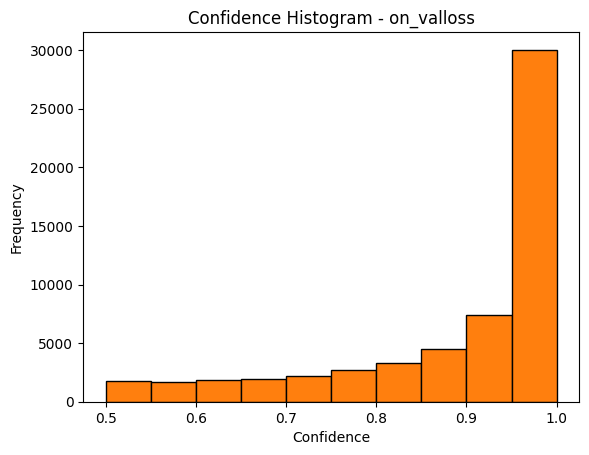

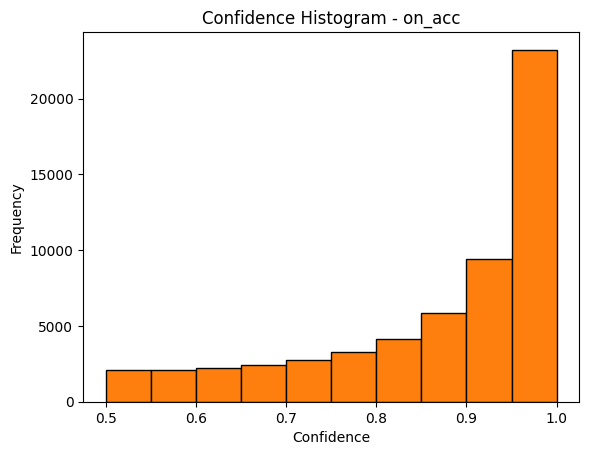

In [154]:
plot_df_submit(df_submit_on_valloss,"on_valloss")
plot_df_submit(df_submit_on_acc,"on_acc")

### 3.1 Kaggle Submission
* The model that performed best on accuracy did better than the model that did best on validation loss.

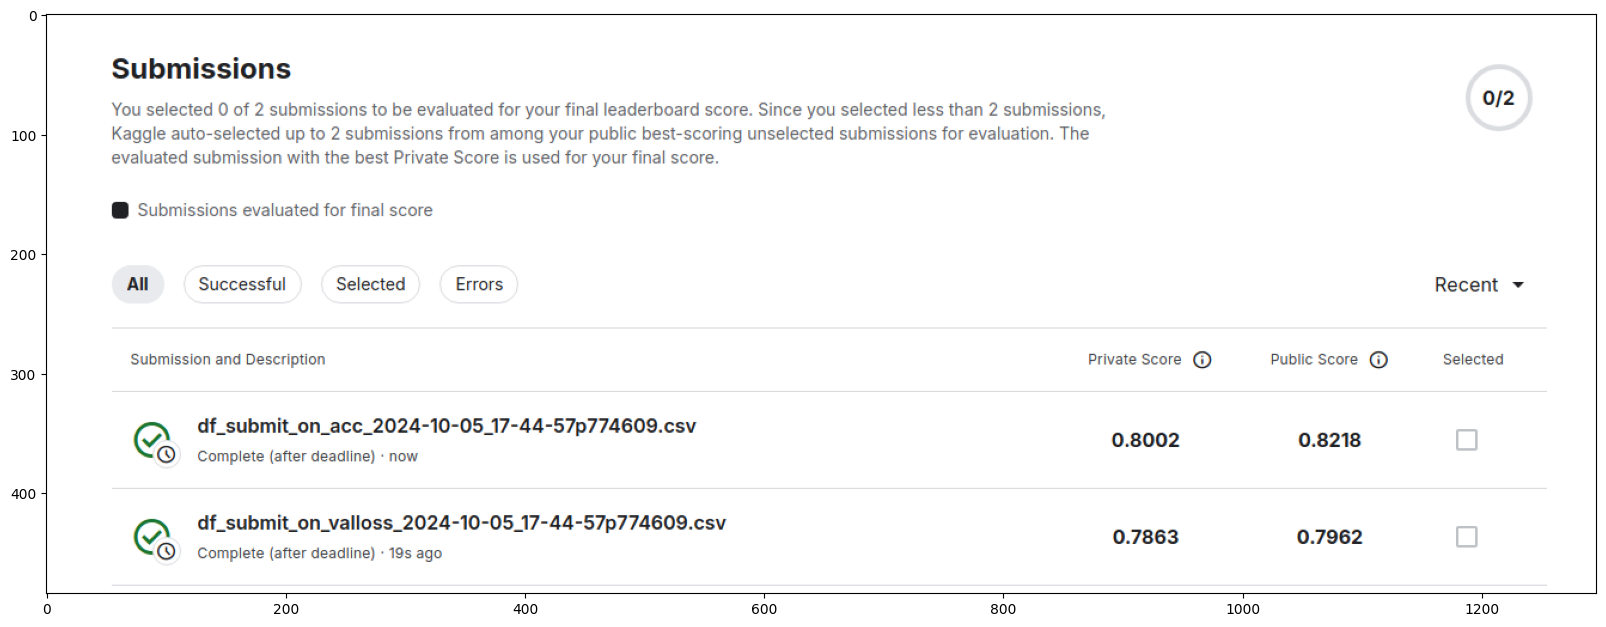

In [160]:
plt.figure(figsize=(20, 8))
plt.imshow(plt.imread("Screenshot from 2024-10-05 18-50-45.png"))
plt.show()

# 4. Conclusion
* It appears that a larger architecture peforms better than a smaller one due to the large amount of diversity in the dataset that overfitting is less of an issue.  
* When training YOLOv8 classifier models, *SGD* outperforms *AdamN*.
* Performance was not significantly improved by the different augmentation policies I used with training.
    * Future efforts might explore more augmentation policies to see greater differences in test results.
* Possibly training on all of the data in the end could yield a better model on the real test set than just using 80% of the data due to the diversity.
* It appears that a model optimized for model accuracy will out perform optmized for validation loss.